## Семестр 2. Задание 5. Параллельное умножение матриц

In [1]:
import numpy as np
import numba
from numba import cuda, types
np.random.seed(123)

### Последовательный N = 1000

## Проверка умножения матриц

In [158]:
N = 5
A = np.random.random((N, N))
B = np.random.random((N, N))
C = np.zeros((N,N))

### Будем считать Numpy умножение матриц за истину 

In [159]:
C = A @ B
print(C)

[[1.24633576 1.28683415 1.64083231 1.13957765 1.23888875]
 [1.09272953 1.2547706  1.97145492 1.74511452 1.36381602]
 [0.55267315 0.67800898 0.97631018 0.89538629 0.8422766 ]
 [0.78151756 0.95564806 1.11213785 1.06386442 1.42065134]
 [0.7012217  0.98997644 1.37705702 0.91002336 0.91051555]]


### Последоватльный вариант блочным разделением

In [ ]:
C = np.zeros((N,N))
for k in range(N):
  for j in range(N):
      for i in range(N):
        C[i][j] = C[i][j] + A[i][k] * B[k][j]
print(C)

[[1.24633576 1.28683415 1.64083231 1.13957765 1.23888875]
 [1.09272953 1.2547706  1.97145492 1.74511452 1.36381602]
 [0.55267315 0.67800898 0.97631018 0.89538629 0.8422766 ]
 [0.78151756 0.95564806 1.11213785 1.06386442 1.42065134]
 [0.7012217  0.98997644 1.37705702 0.91002336 0.91051555]]


### Параллельный варинат с использованием shared-памяти

In [2]:
@cuda.jit
def matMult(a, b, n, c, BLOCK_SIZE):
  bx = cuda.blockIdx.x
  by = cuda.blockIdx.y
  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y

  a_begin = n * BLOCK_SIZE * by
  a_end = a_begin + n - 1
  b_begin = BLOCK_SIZE * bx

  a_step = BLOCK_SIZE
  b_step = BLOCK_SIZE * n

  sum = 0.0
  
  ib = b_begin
  ia = a_begin
  while ia <= a_end:
    a_s = cuda.shared.array((16, 16), types.float32)
    b_s = cuda.shared.array((16, 16), types.float32)
    a_s[ty][tx] = a[ia + n * ty + tx]
    b_s[ty][tx] = b[ib + n * ty + tx]
    cuda.syncthreads()
    for k in range(BLOCK_SIZE):
      sum += a_s[ty][k] * b_s[k][tx]
    cuda.syncthreads()
    ia += a_step
    ib += b_step
  c[n * BLOCK_SIZE * by + BLOCK_SIZE * bx + n * ty + tx] = sum

In [162]:
BLOCK_SIZE = 16
TBP = (BLOCK_SIZE, BLOCK_SIZE)
BPG = (N // BLOCK_SIZE + 1, N // BLOCK_SIZE + 1)
print(TBP, BPG)

(16, 16) (1, 1)


In [164]:
A_device = cuda.to_device(A.flatten())
B_device = cuda.to_device(B.flatten())
C = np.zeros((N,N))
C_device = cuda.to_device(C.flatten())

matMult[BPG, TBP](A_device, B_device, N, C_device, BLOCK_SIZE)
res = C_device.copy_to_host()
print(res.reshape(N,N))

[[1.24633574 1.28683414 1.64083234 1.13957765 1.23888873]
 [1.09272949 1.25477056 1.97145489 1.74511446 1.36381599]
 [1.47411641 1.67141527 1.83209994 1.5199552  1.57032068]
 [1.11763349 1.44766977 1.45079969 1.29790789 1.78663206]
 [0.70122171 0.98997647 1.37705704 0.91002337 0.91051554]]


## Сравнение скорости последовательного и параллельного алгоритма

### Последовательный N = 100

In [20]:
N = 100
A = np.random.random((N, N))
B = np.random.random((N, N))
C = np.zeros((N,N))

In [21]:
%%time
for k in range(N):
  for j in range(N):
      for i in range(N):
        C[i][j] = C[i][j] + A[i][k] * B[k][j]

CPU times: user 1.28 s, sys: 10 μs, total: 1.28 s
Wall time: 1.28 s


### Параллельный N = 100

In [22]:
C = np.zeros((N,N))
BLOCK_SIZE = 16
TBP = (BLOCK_SIZE, BLOCK_SIZE)
BPG = (N // BLOCK_SIZE + 1, N // BLOCK_SIZE + 1)
print(TBP, BPG)

(16, 16) (7, 7)


In [23]:
%%time
A_device = cuda.to_device(A.flatten())
B_device = cuda.to_device(B.flatten())
C_device = cuda.to_device(C.flatten())

matMult[BPG, TBP](A_device, B_device, N, C_device, BLOCK_SIZE)

CPU times: user 5.13 ms, sys: 0 ns, total: 5.13 ms
Wall time: 4.18 ms


### Последовательный N = 500

In [27]:
N = 500
A = np.random.random((N, N))
B = np.random.random((N, N))
C = np.zeros((N,N))

In [28]:
%%time
for k in range(N):
  for j in range(N):
      for i in range(N):
        C[i][j] = C[i][j] + A[i][k] * B[k][j]

CPU times: user 2min 34s, sys: 33.2 ms, total: 2min 34s
Wall time: 2min 34s


### Параллельный N = 500

In [29]:
C = np.zeros((N,N))
BLOCK_SIZE = 16
TBP = (BLOCK_SIZE, BLOCK_SIZE)
BPG = (N // BLOCK_SIZE + 1, N // BLOCK_SIZE + 1)
print(TBP, BPG)

(16, 16) (32, 32)


In [30]:
%%time
A_device = cuda.to_device(A.flatten())
B_device = cuda.to_device(B.flatten())
C_device = cuda.to_device(C.flatten())

matMult[BPG, TBP](A_device, B_device, N, C_device, BLOCK_SIZE)

CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 15.4 ms


### Последовательный N = 1000

In [33]:
N = 1000
A = np.random.random((N, N))
B = np.random.random((N, N))
C = np.zeros((N,N))

In [34]:
%%time
for k in range(N):
  for j in range(N):
      for i in range(N):
        C[i][j] = C[i][j] + A[i][k] * B[k][j]

CPU times: user 20min 50s, sys: 228 ms, total: 20min 50s
Wall time: 20min 50s


### Параллельный N = 1000

In [39]:
C = np.zeros((N,N))
BLOCK_SIZE = 16
TBP = (BLOCK_SIZE, BLOCK_SIZE)
BPG = (N // BLOCK_SIZE + 1, N // BLOCK_SIZE + 1)
print(TBP, BPG)

(16, 16) (63, 63)


In [41]:
%%time
A_device = cuda.to_device(A.flatten())
B_device = cuda.to_device(B.flatten())
C_device = cuda.to_device(C.flatten())

matMult[BPG, TBP](A_device, B_device, N, C_device, BLOCK_SIZE)

CPU times: user 200 ms, sys: 22.3 ms, total: 222 ms
Wall time: 222 ms


## Сравнение результатов по времени

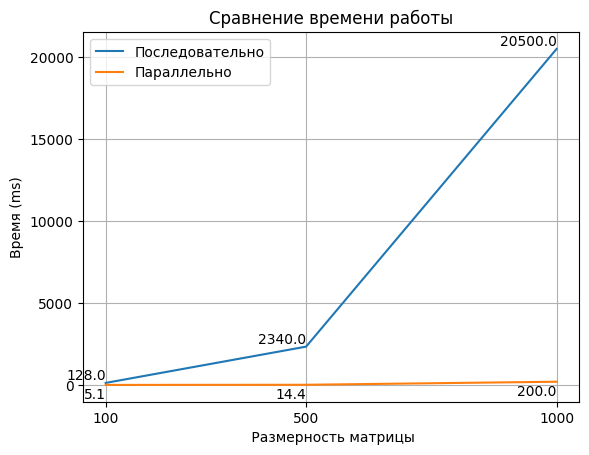

In [1]:
import matplotlib.pyplot as plt

ns = [100, 500, 1000]
s_times = [128., 2340., 20500.]
p_times = [5.13, 14.4, 200.]

plt.plot(ns, s_times)
plt.plot(ns, p_times)
for x, y in zip(ns, s_times):
    plt.text(x, y, f'{y:.1f}', ha='right', va='bottom')

for x, y in zip(ns, p_times):
    plt.text(x, y-1000, f'{y:.1f}', ha='right', va='bottom')
plt.title("Сравнение времени работы")
plt.xlabel(" Размерность матрицы")
plt.ylabel("Время (ms)")
plt.grid(True)
plt.legend(['Последовательно', 'Параллельно'])
plt.xticks(ns)
plt.show()